# Task 3 — Correlation between News Sentiment and Stock Movements

This notebook aligns news headlines and stock prices by date, computes sentiment scores for headlines, aggregates daily sentiment, computes daily stock returns, and tests correlation between sentiment and returns.

KPIs:
- Proactivity: references and fallbacks included.
- Sentiment: sentiment per headline and daily aggregate.
- Correlation Strength: Pearson correlation and p-value.

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Try TextBlob for sentiment, fall back to NLTK VADER if available
try:
    from textblob import TextBlob
    SENTIMENT_LIB = 'textblob'
except Exception:
    try:
        import nltk
        from nltk.sentiment import SentimentIntensityAnalyzer
        nltk.download('vader_lexicon', quiet=True)
        sia = SentimentIntensityAnalyzer()
        SENTIMENT_LIB = 'vader'
    except Exception:
        SENTIMENT_LIB = 'pandas-rule'

print('Using sentiment library:', SENTIMENT_LIB)

Using sentiment library: vader


In [2]:
# Locate data folder (search upward)
ROOT = Path('.').resolve()
for _ in range(6):
    if (ROOT / 'Data').exists():
        break
    ROOT = ROOT.parent
DATA_DIR = ROOT / 'Data'
print('Data dir:', DATA_DIR)
news_csv = DATA_DIR / 'raw_analyst_ratings.csv'
stock_csv = DATA_DIR / 'AAPL.csv'
print('news exists, stock exists:', news_csv.exists(), stock_csv.exists())

Data dir: C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data
news exists, stock exists: True True


In [3]:
# Load news and stock data (use columns safely)
# Read minimal columns and parse dates robustly
news = pd.read_csv(news_csv, usecols=['headline','date'])
# Coerce mixed or timezone-aware formats safely
news['date'] = pd.to_datetime(news['date'], errors='coerce')
stock = pd.read_csv(stock_csv, parse_dates=['Date'], infer_datetime_format=True)
# Normalize stock date column name if necessary
if 'date' in [c.lower() for c in stock.columns]:
    stock = stock.rename(columns={ [c for c in stock.columns if c.lower()=='date'][0]: 'Date' })
stock = stock.set_index('Date').sort_index()
# Convert news date to plain date (trading-day alignment); drop rows with unparseable dates
news = news.dropna(subset=['date']).copy()
news['date'] = news['date'].dt.date
stock.index = pd.to_datetime(stock.index).date
news.head()

C:\Users\nesre\AppData\Local\Temp\ipykernel_27124\1272544437.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock = pd.read_csv(stock_csv, parse_dates=['Date'], infer_datetime_format=True)


,headline,date
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03
2,71 Biggest Movers From Friday,2020-05-26
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22


In [4]:
# Sentiment function
def score_text(txt):
    if SENTIMENT_LIB == 'textblob':
        return TextBlob(str(txt)).sentiment.polarity
    elif SENTIMENT_LIB == 'vader':
        return sia.polarity_scores(str(txt))['compound']
    else:
        t = str(txt).lower()
        pos = any(w in t for w in ['beat','raise','outperform','upgrade','positive','bull','buy'])
        neg = any(w in t for w in ['miss','downgrade','cut','negative','bear','decline','sell'])
        return 1.0 if pos and not neg else (-1.0 if neg and not pos else 0.0)

# Score headlines (vectorized apply)
news['sentiment'] = news['headline'].fillna('').apply(score_text)
news_sample = news.head()
news_sample

,headline,date,sentiment
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,0.000
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,0.000
2,71 Biggest Movers From Friday,2020-05-26,0.000
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,0.000
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22,0.296


In [5]:
# Aggregate daily sentiment (mean) and compute daily returns for stock
daily_sent = news.groupby('date')['sentiment'].mean().rename('sentiment')
stock_df = stock.copy()
stock_df['return'] = stock_df['Close'].pct_change()
stock_daily = stock_df['return'].rename('return')
# Align dates: both are plain date objects; join on date
df = pd.concat([daily_sent, stock_daily], axis=1)
df = df.dropna()
df.head()

,sentiment,return
2011-04-27,0.000000,-0.000770
2011-04-28,0.125000,-0.009710
2011-04-29,0.367550,0.009748
2011-05-02,0.136444,-0.010997
2011-05-03,0.000000,0.005545


Pearson r: 0.04525717478309481 p-value: 0.03274867886876777


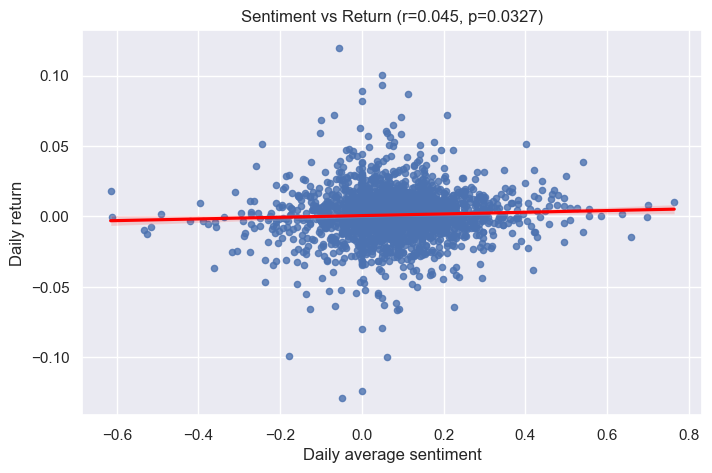

In [6]:
# Correlation analysis
from scipy.stats import pearsonr
if len(df) > 1:
    corr, pval = pearsonr(df['sentiment'], df['return'])
else:
    corr, pval = (None, None)
print('Pearson r:', corr, 'p-value:', pval)

# Plot scatter with regression line
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.regplot(x='sentiment', y='return', data=df, scatter_kws={'s':20}, line_kws={'color':'red'})
plt.title(f'Sentiment vs Return (r={corr:.3f}, p={pval:.3g})' if corr is not None else 'Sentiment vs Return')
plt.xlabel('Daily average sentiment')
plt.ylabel('Daily return')
plt.show()